# Prediction intervals in multi-step forecasting models

When trying to anticipate future values, most of forecasting models try to predict what will be the most likely value, this is call point-forecasting. Although knowing in advance the expected value of a time series is useful in almost every business case, this kind of prediction does not provide any information about the confidence of the model nor the prediction uncertainty.

Probabilistic forecasting, as opposed to point-forecasting, is a family of techniques that allow for predicting the expected distribution of the outcome instead of a single future value. This type of forecasting provides much rich information since it allows for creating prediction intervals, the range of likely values where the true value may fall. More formally, a prediction interval defines the interval within which the true value of the response variable is expected to be found with a given probability.

There are [multiple ways to estimate prediction intervals](https://otexts.com/fpp3/prediction-intervals.html), most of which require that the residuals (errors) of the model follow a normal distribution. When this property cannot be assumed, two alternatives commonly used are: bootstrapping and quantile regression. In order to illustrate how [skforecast](https://joaquinamatrodrigo.github.io/skforecast/) allows to estimate prediction intervals for multi-step forecasting, the following examples attempt to predict the energy demand for an horizon of 7 days at hourly level. Two strategies are shown:

+ Prediction intervals based on bootstrapped residuals and [recursive-multi-step forecaster](https://joaquinamatrodrigo.github.io/skforecast/latest/notebooks/autoregresive-forecaster.html).

+ Prediction intervals based on quantile regression and [direct-multi-step forecaster](https://joaquinamatrodrigo.github.io/skforecast/latest/notebooks/direct-multi-step-forecasting.html).
<br>


<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100;">

<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b> &nbsp Warning</b>
</p>

As Rob J Hyndman explain in his [blog](https://robjhyndman.com/hyndsight/narrow-pi/), in real-world problems, almost all prediction intervals are too narrow. For example, nominal 95% intervals may only provide coverage between 71% and 87%. This is a well-known phenomenon and arises because they do not account for all sources of uncertainty. In the case of forecasting models, there are at least four sources of uncertainty:

+ The random error term

+ The parameter estimates

+ The choice of model for the historical data

+ The continuation of the historical data generating process into the future

When producing prediction intervals for time series models, generally only the first of these sources is taken into account. Therefore, it is advisable to use test data to validate the empirical coverage of the interval and not only rely on the expected one.

</div>

## Prediction intervals using bootstrapped residuals

The error of one-step-ahead forecast is defined as $e_t = y_t - \hat{y}_{t|t-1}$. Assuming future errors will be like past errors, it is possible to simulate different predictions by sampling from the collection of errors previously seen in the past (i.e., the residuals) and adding them to the predictions.

<p align="center"><img src="../img/diagram-bootstrapping-prediction-intervals.png" style="width: 700px;"></p>

Doing this repeatedly, a collection of slightly different predictions is created (possible future paths), that represent the expected variance in the forecasting process. 

<p align="center"><img src="../img/diagram-bootstrapping-prediction-intervals-2.png" style="width: 500px;"></p>

Finally, prediction intervals can be computed by calculating the $α/2$ and $1 − α/2$ percentiles of the simulated data
at each forecasting horizon.

<p align="center"><img src="../img/forecasting-intervals.gif" style="width: 900px;"></p>
<br>

The main advantage of this strategy is that it only require a single model to estimate any interval. The drawback is that, running hundreds or thousands of bootstrapping iterations, is computationally very expensive and not always feasible.

This type of prediction intervals can be easily estimated using [ForecasterAutoreg](https://joaquinamatrodrigo.github.io/skforecast/latest/api/ForecasterAutoreg.html) and [ForecasterAutoregCustom](https://joaquinamatrodrigo.github.io/skforecast/latest/api/ForecasterAutoregCustom.html) models.

## Prediction intervals using quantile regression models


As opposed to linear regression, intended to estimate the conditional mean of the response variable given certain values of the predictor variables, quantile regression aims at estimating conditional quantiles of the response variable. For a continuous distribution function, the $\alpha$-quantile $Q_{\alpha}(x)$ is defined such that the probability of $Y$ being smaller than $Q_{\alpha}(x)$ is, for a given $X=x$, equal to $\alpha$. For example, 36% of the population values are lower than the quantile  $Q=0.36$. The most known quantile is the 50%-quantile, most commonly named as median.

By combining the predictions of two quantile regressors, it is possible to build an interval. Each model estimates one of the limits of the interval. For example, the models obtained for $Q = 0.1$ and $Q = 0.9$ produce a 80% prediction interval (90% - 10% = 80%).

There are several machine learning algorithms than are capable of modeling quantiles, some of them are:

+ [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)

+ [XGBoost](https://xgboost.readthedocs.io/en/stable/python/index.html)

+ [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor)

+ [sklearn GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)

+ [sklearn QuantileRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor)

+ [skranger quantile RandomForest](https://skranger.readthedocs.io/en/stable/index.html)


Just as the squared-error loss function is used to train models that predict the mean value, a specific loss function is needed in order train models that predict quantiles. The most common metric used for quantile regression is call [quantile loss  or pinball loss](https://en.wikipedia.org/wiki/Quantile_regression):


$$\text{pinball}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1}  \alpha \max(y_i - \hat{y}_i, 0) + (1 - \alpha) \max(\hat{y}_i - y_i, 0)$$

where $\alpha$ is the target quantile, $y$ the real value and $\hat{y}$ the quantile prediction.

It can be seen that loss differs depending on the evaluated quantile. The higher the quantile, the more the loss function penalizes underestimates and the less it penalizes overestimates. As with MSE and MAE, the goal is to minimize its values (the lower loss, the better).

Two disadvantages of quantile regression, compared to the bootstrap approach to prediction intervals, is that each quantile needs its own regressor and quantile regression is not available for all types of regression models. However, once the models are trained, the inference is much faster since no iterative process is needed.

This type of prediction intervals can be easily estimated using [ForecasterAutoregMultiOutput](https://joaquinamatrodrigo.github.io/skforecast/latest/api/ForecasterAutoregMultiOutput.html) models.

## Libraries

In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
import plotly.graph_objects as go
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_pinball_loss

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')
%config Completer.use_jedi = False

## Data

Data used in this document were obtained from the R [tsibbledata](https://tsibbledata.tidyverts.org/reference/vic_elec.html) package. The dataset contains half-hourly electricity demand for Victoria (Australia) and additional information about the temperature and an indicator for if that day is a public holiday. In the following examples, data is aggregated at daily level.

In [2]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')

# Data preparation (aggregation at daily level)
# ==============================================================================
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data = data.drop(columns='Date')
data = data.resample(rule='D', closed='left', label ='right')\
       .agg({'Demand': 'sum', 'Temperature': 'mean', 'Holiday': 'max'})
data.head()

,Demand,Temperature,Holiday
Time,,,
2012-01-01,82531.745918,21.047727,True
2012-01-02,227778.257304,26.578125,True
2012-01-03,275490.988882,31.751042,True
2012-01-04,258955.329422,24.567708,False
2012-01-05,213792.376946,18.191667,False


In [3]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
end_validation = '2014-9-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2012-01-01 00:00:00 --- 2013-12-31 00:00:00  (n=731)
Validation dates : 2014-01-01 00:00:00 --- 2014-09-30 00:00:00  (n=273)
Test dates       : 2014-10-01 00:00:00 --- 2014-12-30 00:00:00  (n=91)


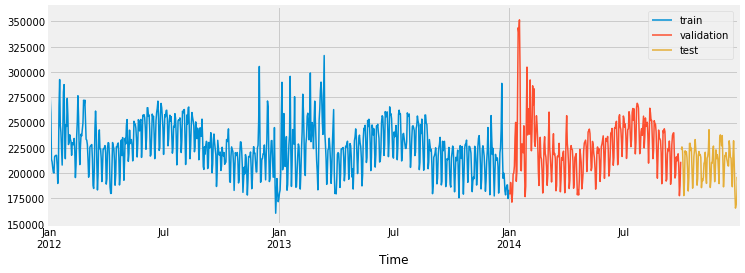

In [4]:
# Plot time serie partition
# ==============================================================================
fig, ax=plt.subplots(figsize=(11, 4))
data_train['Demand'].plot(label='train', ax=ax);
data_val['Demand'].plot(label='validation', ax=ax);
data_test['Demand'].plot(label='test', ax=ax)
ax.set_ylim(bottom=150_000);
ax.legend();

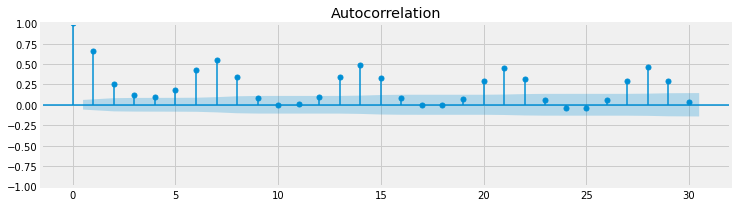

In [5]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 3))
plot_acf(data.Demand, ax=ax, lags=30)
plt.show()

Base on the autocorrelation plot, the last 7 days may be used as predictors.

## Bootstrapping prediction intervals

A recursive-multi-step forecaster is trained and its hyper-parameters optimized. Then, prediction intervals based on bootstrapped residuals are estimated.

In [6]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(),
                lags = 7
            )
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor() 
Lags: [1 2 3 4 5 6 7] 
Window size: 7 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-04-12 22:26:22 
Last fit date: None 
Skforecast version: 0.4.3 

In order to find the best value for the hyper-parameters, a [grid search](https://joaquinamatrodrigo.github.io/skforecast/latest/notebooks/grid-search-forecaster.html) is carried out. It is important not to include test data in the search, otherwise model overfitting could happen.

In [7]:
# Grid search of hyper-parameters and lags
# ==============================================================================
# Regressor hyper-parameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [7]

results_grid_q10 = grid_search_forecaster(
                            forecaster         = forecaster,
                            y                  = data.loc[:end_validation, 'Demand'],
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = 7,
                            refit              = True,
                            metric             = 'mean_squared_error',
                            initial_train_size = int(len(data_train)),
                            return_best        = True,
                            verbose            = False
                    )

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [01:29<00:00, 89.58s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 385319031.88926536



Once the best hyper-parameters have been found, a backtesting process is applied in order to evaluate the forecaster performance on test data, and calculate the real coverage of the estimated interval.

In [8]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = data['Demand'],
                            initial_train_size = len(data_train) + len(data_val),
                            steps      = 7,
                            refit      = True,
                            interval   = [10, 90],
                            n_boot     = 1000,
                            metric     = 'mean_squared_error',
                            verbose    = False
                        )
predictions.head(4)

,pred,lower_bound,upper_bound
2014-10-01,225166.460881,212468.082618,237934.732385
2014-10-02,229586.201508,214144.566479,245619.699520
2014-10-03,228615.742762,213233.590926,250693.382802
2014-10-04,214619.689935,194065.763914,238486.905575


In [9]:
# Interval coverage on test data
# ==============================================================================
inside_interval = np.where(
                     (data.loc[predictions.index, 'Demand'] >= predictions['lower_bound']) & \
                     (data.loc[predictions.index, 'Demand'] <= predictions['upper_bound']),
                     True,
                     False
                  )

coverage = inside_interval.mean()
print(f"Coverage of the predicted interval on test data: {100 * coverage}")

Coverage of the predicted interval on test data: 75.82417582417582


The coverage of the predicted interval (76%) is slightly lower than the expected (80%).

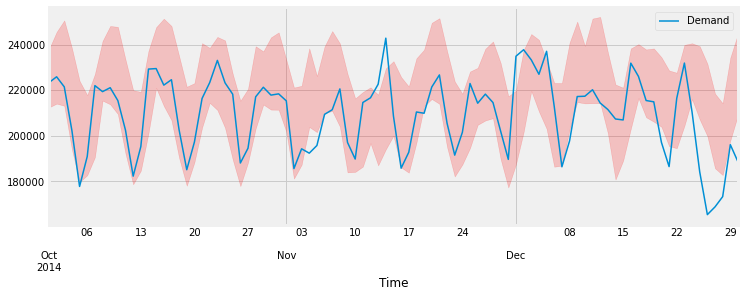

In [10]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(11, 4))
data.loc[end_validation:, 'Demand'].plot(ax=ax, label='Demand')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

By default, training residuals are used to create the prediction intervals. However, other residuals may be used, for example, residuals obtained from a validation set.

First, the new residuals must be stored inside the forecaster using the method `set_out_sample_residuals`. Once the new residuals have been added to the forecaster, it is possible to indicate `in_sample_residuals = False` when using the `predict` method.

In [11]:
# Simulated residuals
simulated_residuals = pd.Series(np.random.normal(size=500))
forecaster.set_out_sample_residuals(residuals=simulated_residuals)

## Quantile regression models

As in the previous example, a 80% prediction interval is estimated for 7 steps-ahead predictions but, this time, using quantile regression. A LightGBM gradient boosting model is trained in this example, however, the reader may use any other model just replacing the definition of the regressor.

In [12]:
# Create forecasters: one for each limit of the interval
# ==============================================================================
# The forecasters obtained for alpha=0.1 and alpha=0.9 produce a 80% confidence
# interval (90% - 10% = 80%).

# Forecaster for quantile 10%
forecaster_q10 = ForecasterAutoregMultiOutput(
                    regressor = LGBMRegressor(
                                    objective     = 'quantile',
                                    metric        = 'quantile',
                                    alpha         = 0.1,
                                    learning_rate = 0.1,
                                    max_depth     = 10,
                                    n_estimators  = 100
                                ),
                    lags = 7,
                    steps = 7
                  )
# Forecaster for quantile 90%
forecaster_q90 = ForecasterAutoregMultiOutput(
                    regressor = LGBMRegressor(
                                    objective     = 'quantile',
                                    metric        = 'quantile',
                                    alpha         = 0.9,
                                    learning_rate = 0.1,
                                    max_depth     = 10,
                                    n_estimators  = 100
                                ),
                    lags = 7,
                    steps = 7
                  )

When validating a quantile regression model, a custom metric must be provided depending on the quantile being estimated. This metrics will be used again when tuning the hyper-parameters of each model.

In [13]:
# Loss function for each quantile (pinball_loss)
# ==============================================================================
def mean_pinball_loss_q10(y_true, y_pred):
    '''
    Pinball loss for quantile 10.
    '''
    return mean_pinball_loss(y_true, y_pred, alpha=0.1)


def mean_pinball_loss_q90(y_true, y_pred):
    '''
    Pinball loss for quantile 90.
    '''
    return mean_pinball_loss(y_true, y_pred, alpha=0.9)

In [14]:
# Backtesting on test data
# ==============================================================================
metric_q10, predictions_q10 = backtesting_forecaster(
                                    forecaster = forecaster_q10,
                                    y          = data['Demand'],
                                    initial_train_size = len(data_train) + len(data_val),
                                    steps      = 7,
                                    refit      = True,
                                    metric     = mean_pinball_loss_q10,
                                    verbose    = False
                                )

metric_q90, predictions_q90 = backtesting_forecaster(
                                    forecaster = forecaster_q90,
                                    y          = data['Demand'],
                                    initial_train_size = len(data_train) + len(data_val),
                                    steps      = 7,
                                    refit      = True,
                                    metric     = mean_pinball_loss_q90,
                                    verbose    = False
                                )

Predictions generated for each model are used to define the upper and lower limits of the interval.

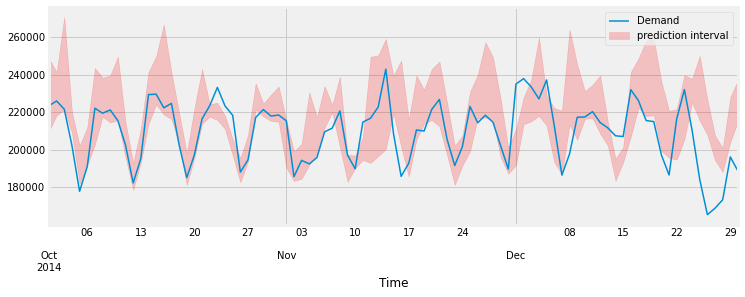

In [15]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(11, 4))
data.loc[end_validation:, 'Demand'].plot(ax=ax, label='Demand')
ax.fill_between(
    data.loc[end_validation:].index,
    predictions_q10['pred'],
    predictions_q90['pred'],
    color = 'red',
    alpha = 0.2,
    label = 'prediction interval'
)
ax.legend();

In [16]:
# Interval coverage on test data
# ==============================================================================
inside_interval = np.where(
                     (data.loc[end_validation:, 'Demand'] >= predictions_q10['pred']) & \
                     (data.loc[end_validation:, 'Demand'] <= predictions_q90['pred']),
                     True,
                     False
                   )

coverage = inside_interval.mean()
print(f"Coverage of the predicted interval: {100 * coverage}")

Coverage of the predicted interval: 59.34065934065934


The coverage of the predicted interval (59%) is much lower than the expected (80%).

The hyper-parameters of the model were hand-tuned and there is no reason that the same hyper-parameters are suitable for the 10th and 90th percentiles regressors, therefore, a grid search is carried out for each forecaster.

In [17]:
# Grid search of hyper-parameters and lags for each quantile forecaster
# ==============================================================================
# Regressor hyper-parameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [7]

results_grid_q10 = grid_search_forecaster(
                            forecaster         = forecaster_q10,
                            y                  = data.loc[:end_validation, 'Demand'],
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = 7,
                            refit              = False,
                            metric             = mean_pinball_loss_q10,
                            initial_train_size = int(len(data_train)),
                            return_best        = True,
                            verbose            = False
                    )

results_grid_q90 = grid_search_forecaster(
                            forecaster         = forecaster_q90,
                            y                  = data.loc[:end_validation, 'Demand'],
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = 7,
                            refit              = False,
                            metric             = mean_pinball_loss_q90,
                            initial_train_size = int(len(data_train)),
                            return_best        = True,
                            verbose            = False
                    )

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:10<00:00, 10.07s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 2713.0192469016706

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:11<00:00, 11.79s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 4094.3047516967745



Once the best hyper-parameters have been found for each forecaster, a backtesting process is applied again using the test data.

In [18]:
# Backtesting on test data
# ==============================================================================
metric_q10, predictions_q10 = backtesting_forecaster(
                                    forecaster = forecaster_q10,
                                    y          = data['Demand'],
                                    initial_train_size = len(data_train) + len(data_val),
                                    steps      = 7,
                                    refit      = False,
                                    metric     = mean_pinball_loss_q10,
                                    verbose    = False
                                )

metric_q90, predictions_q90 = backtesting_forecaster(
                                    forecaster = forecaster_q90,
                                    y          = data['Demand'],
                                    initial_train_size = len(data_train) + len(data_val),
                                    steps      = 7,
                                    refit      = False,
                                    metric     = mean_pinball_loss_q90,
                                    verbose    = False
                                )

In [19]:
# Interval coverage
# ==============================================================================
inside_interval = np.where(
                     (data.loc[end_validation:, 'Demand'] >= predictions_q10['pred']) & \
                     (data.loc[end_validation:, 'Demand'] <= predictions_q90['pred']),
                     True,
                     False
                   )

coverage = inside_interval.mean()
print(f"Coverage of the predicted interval: {100 * coverage}")

Coverage of the predicted interval: 75.82417582417582


After optimizing the hyper-parameters of each quantile forecaster, the coverage is closer to the expected one (80%).

In [20]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>